In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from fastai.tabular.all import *
import betting.feature_engineering as features

# Analysis of datahub odds with metadata

In [8]:
data_path = Path('../data/datahub/with_meta.feather')
raw_df = pd.read_feather(data_path)
raw_df.head()

,Date,home_odds,draw_odds,away_odds,season,league,matchday,home_team,away_team,home_goals,...,home_total_goals_received,home_points,away_rank,away_games_played,away_wins,away_draw,away_lost,away_total_goals_scored,away_total_goals_received,away_points
0,2009-08-22,1.17,7.00,19.00,2009,premier_league,3,Arsenal,Portsmouth,4,...,1,3,20,1,0,0,1,0,1,-9
1,2009-08-22,2.30,3.20,3.25,2009,premier_league,3,Birmingham,Stoke City,0,...,1,0,2,1,1,0,0,2,0,3
2,2009-08-22,2.60,3.25,2.80,2009,premier_league,3,Hull City,Bolton,1,...,2,0,13,1,0,0,1,0,1,0
3,2009-08-22,1.33,4.50,12.00,2009,premier_league,3,Man City,Wolverhampton,1,...,0,3,15,1,0,0,1,0,2,0
4,2009-08-22,2.10,3.25,3.75,2009,premier_league,3,Sunderland,Blackburn,2,...,0,3,15,1,0,0,1,0,2,0


In [9]:
raw_df.shape, raw_df.columns

((17275, 27),
 Index(['Date', 'home_odds', 'draw_odds', 'away_odds', 'season', 'league',
        'matchday', 'home_team', 'away_team', 'home_goals', 'away_goals',
        'home_rank', 'home_games_played', 'home_wins', 'home_draw', 'home_lost',
        'home_total_goals_scored', 'home_total_goals_received', 'home_points',
        'away_rank', 'away_games_played', 'away_wins', 'away_draw', 'away_lost',
        'away_total_goals_scored', 'away_total_goals_received', 'away_points'],
       dtype='object'))

## Results, target columns

In [11]:
raw_df['result'] = features.results_from_goals(raw_df, 'home_goals', 'away_goals')

In [12]:
raw_df = features.add_profit_cols(raw_df, 'home_odds', 'draw_odds', 'away_odds')
raw_df['y_none'] = 0.
raw_df.head()

,Date,home_odds,draw_odds,away_odds,season,league,matchday,home_team,away_team,home_goals,...,away_draw,away_lost,away_total_goals_scored,away_total_goals_received,away_points,result,y_home,y_draw,y_away,y_none
0,2009-08-22,1.17,7.00,19.00,2009,premier_league,3,Arsenal,Portsmouth,4,...,0,1,0,1,-9,-1,0.17,-1.0,-1.0,0.0
1,2009-08-22,2.30,3.20,3.25,2009,premier_league,3,Birmingham,Stoke City,0,...,0,0,2,0,3,0,-1.00,2.2,-1.0,0.0
2,2009-08-22,2.60,3.25,2.80,2009,premier_league,3,Hull City,Bolton,1,...,0,1,0,1,0,-1,1.60,-1.0,-1.0,0.0
3,2009-08-22,1.33,4.50,12.00,2009,premier_league,3,Man City,Wolverhampton,1,...,0,1,0,2,0,-1,0.33,-1.0,-1.0,0.0
4,2009-08-22,2.10,3.25,3.75,2009,premier_league,3,Sunderland,Blackburn,2,...,0,1,0,2,0,-1,1.10,-1.0,-1.0,0.0


## Validation

In [13]:
raw_df.season.unique()

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
      dtype=int32)

In [289]:
raw_df['valid'] = False
raw_df.loc[raw_df.season==2018,'valid'] = True

## DataLoaders

In [33]:
cats = ['league']
conts = ['season', 'matchday',
        'home_rank', 'home_games_played', 'home_wins', 'home_draw', 'home_lost',
        'home_total_goals_scored', 'home_total_goals_received', 'home_points',
        'away_rank', 'away_games_played', 'away_wins', 'away_draw', 'away_lost',
        'away_total_goals_scored', 'away_total_goals_received', 'away_points']

In [34]:
to = TabularPandas(raw_df, cat_names=cats, procs=[Categorify, Normalize],
                   cont_names = conts,
                   y_names=['y_home', 'y_draw', 'y_away', 'y_none'],
                   splits=ColSplitter('valid')(raw_df))
dls = to.dataloaders(bs=4096)

In [35]:
dls.show_batch()

,league,season,matchday,home_rank,home_games_played,home_wins,home_draw,home_lost,home_total_goals_scored,home_total_goals_received,home_points,away_rank,away_games_played,away_wins,away_draw,away_lost,away_total_goals_scored,away_total_goals_received,away_points,y_home,y_draw,y_away,y_none
0,league_one,2012.0,22.0,9.0,20.0,8.0,5.000000e+00,7.000000e+00,31.000000,24.000000,29.000000,17.0,20.0,5.0,4.0,11.0,20.0,30.000000,19.000000,0.44,-1.00,-1.00,0.0
1,serie_a,2014.0,11.0,15.0,9.0,2.0,3.000000e+00,4.000000e+00,9.000000,17.000000,9.000000,5.0,9.0,5.0,1.0,3.0,11.0,9.000000,16.000000,-1.00,2.30,-1.00,0.0
2,premier_league,2012.0,38.0,14.0,36.0,9.0,1.200000e+01,1.500000e+01,47.000000,57.999998,39.000000,11.0,36.0,9.0,14.0,13.0,32.0,42.000000,41.000000,-1.00,2.80,-1.00,0.0
3,primera_division,2012.0,7.0,1.0,5.0,5.0,-1.627114e-07,-2.208843e-07,14.000000,2.999999,15.000000,7.0,5.0,2.0,1.0,2.0,7.0,4.000001,7.000000,-1.00,3.00,-1.00,0.0
4,premier_league,2009.0,16.0,17.0,14.0,3.0,4.000000e+00,7.000000e+00,14.000000,29.000000,13.000000,14.0,14.0,5.0,2.0,7.0,16.0,28.000000,17.000000,-1.00,2.25,-1.00,0.0
5,serie_a,2015.0,25.0,18.0,23.0,4.0,7.000000e+00,1.200000e+01,22.000000,39.000000,19.000000,5.0,23.0,11.0,8.0,4.0,42.0,25.000000,41.000000,-1.00,-1.00,0.83,0.0
6,primera_division,2016.0,31.0,4.0,29.0,17.0,7.000000e+00,5.000000e+00,52.000001,34.000000,57.999999,16.0,29.0,6.0,9.0,14.0,31.0,46.000001,27.000000,0.50,-1.00,-1.00,0.0
7,primera_division,2016.0,30.0,2.0,28.0,19.0,6.000000e+00,3.000000e+00,80.999999,25.000000,63.000002,3.0,28.0,17.0,6.0,5.0,52.0,34.000000,57.000001,0.22,-1.00,-1.00,0.0
8,league_one,2015.0,36.0,20.0,34.0,3.0,8.000000e+00,2.300000e+01,24.000000,73.000001,17.000000,13.0,34.0,10.0,13.0,11.0,42.0,53.000000,43.000000,-1.00,-1.00,0.73,0.0
9,premier_league,2014.0,36.0,16.0,34.0,8.0,8.000000e+00,1.800000e+01,26.000000,47.999999,32.000000,11.0,34.0,11.0,11.0,12.0,42.0,42.000000,44.000000,0.91,-1.00,-1.00,0.0


# Model

In [36]:
def neg_lr_find(learn, offset=5):
    old_loss = learn.loss_func
    def loss(actuals, targets):
        return offset + old_loss(actuals, targets)
    learn.loss_func = loss
    learn.lr_find()
    learn.loss_func = old_loss

In [53]:
config = tabular_config(ps=.1)

learn = tabular_learner(dls, loss_func=features.odds_loss, metrics=features.odds_profit, layers=[5,5,5], wd=1e-1, config=config)
learn.model = learn.model.to('cuda')

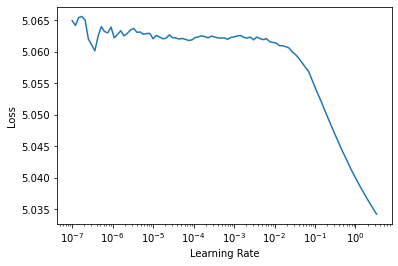

In [54]:
neg_lr_find(learn)

In [55]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,odds_profit,time
0,0.064314,0.049347,-170.542343,00:00
1,0.060428,0.047375,-163.728333,00:00
2,0.057708,0.041408,-143.107010,00:00
3,0.050329,0.031027,-107.229050,00:00
4,0.043299,0.017997,-62.196747,00:00
5,0.037493,0.009868,-34.104530,00:00
6,0.032248,0.005040,-17.417639,00:00
7,0.027793,0.003095,-10.694859,00:00
8,0.024494,0.002647,-9.148397,00:00
9,0.021496,0.002644,-9.138222,00:00


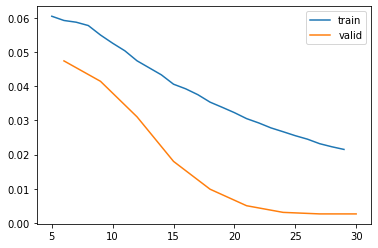

In [56]:
learn.recorder.plot_loss()

## Recent Seasons

In [290]:
recent_df = raw_df.loc[raw_df.season>=2013,:].copy()

In [291]:
cats = ['league']
conts = ['matchday',
        'home_rank', 'home_games_played', 'home_wins', 'home_draw', 'home_lost',
        'home_total_goals_scored', 'home_total_goals_received', 'home_points',
        'away_rank', 'away_games_played', 'away_wins', 'away_draw', 'away_lost',
        'away_total_goals_scored', 'away_total_goals_received', 'away_points']

to = TabularPandas(recent_df, cat_names=cats, procs=[Categorify, Normalize],
                   cont_names = conts,
                   y_names=['y_home', 'y_draw', 'y_away', 'y_none'],
                   splits=ColSplitter('valid')(recent_df))
dls = to.dataloaders(bs=4096)

In [296]:
config = tabular_config(ps=.95)

learn = tabular_learner(dls, loss_func=features.odds_loss, metrics=features.odds_profit, config=config)
learn.model = learn.model.to('cuda')

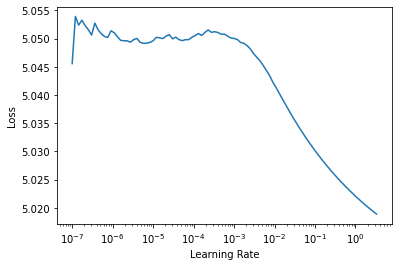

In [293]:
neg_lr_find(learn)

In [297]:
learn.fit_one_cycle(10, 1e-1)

epoch,train_loss,valid_loss,odds_profit,time
0,0.055435,0.037102,-64.112038,00:00
1,0.042134,0.017840,-30.828325,00:00
2,0.028349,0.000347,-0.599214,00:00
3,0.020825,-0.000052,0.089516,00:00
4,0.016318,-0.000003,0.005971,00:00
5,0.013330,-0.000000,0.000386,00:00
6,0.011187,-0.000000,0.000040,00:00
7,0.009583,-0.000000,0.000004,00:00
8,0.008337,-0.000000,0.000000,00:00
9,0.007345,-0.000000,0.000000,00:00


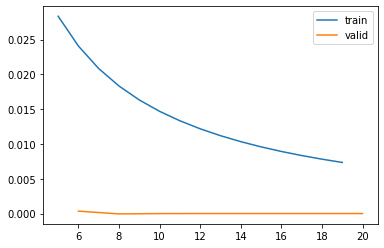

In [298]:
learn.recorder.plot_loss()